# Cancer Diagnosis Prediction 

## Feature Selection

Approach I: 
1. Train base models - Random Forest, SVM and KNN - on all prepared features. 
2. Devide features by logical categories and apply Lasso Regression to select important features within these categories, as well as remove highly correlated between each other features. 
3. Use the models again on selected features. 

In [3]:
import pandas as pd
import numpy as np

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
train_1 = pd.read_csv('train_1.csv') 
test_1 = pd.read_csv('test_1.csv') 

In [6]:
patient_id = test_1['patient_id']

train_1.drop(columns=['patient_id'], axis=1, inplace=True)
test_1.drop(columns=['patient_id'], axis=1, inplace=True)

In [7]:
train_1.isna().sum().sort_values(ascending=False)

patient_zip3                             0
breast_cancer_diagnosis_code_1759        0
breast_cancer_diagnosis_code_C50         0
breast_cancer_diagnosis_code_C5001       0
breast_cancer_diagnosis_code_C50011      0
                                        ..
Region_Northeast                         0
Region_South                             0
Region_West                              0
Division_East North Central              0
metastatic_cancer_diagnosis_code_C799    0
Length: 228, dtype: int64

In [8]:
target = train_1['DiagPeriodL90D']
train_1.drop(columns=target.name, axis=1, inplace=True) 


## Apply Lasso Regression for Feature Selection

In [9]:
# Define dictionary to group columns based on themes
column_groups = {
    'locations': ['patient_state', 'Region', 'Division'],
    'age': ['age'],
    'race': ['race'],
    'education': ['education'],
    'income': ['income'],
    'rent': ['rent'],
    'social_status': ['married', 'divorced', 'widowed'],
    'empl_status': ['labor', 'employ'],
    'home_status': ['home', 'housing'],
    'health_status': ['payer', 'veteran', 'disabled', 'insured'],
    'gender_status': ['male', 'gender'],
    'diagnosis_status': ['diagnosis'],
    'air_quality': ['Ozone', 'PM25', 'N02']
}

# Create dictionary to store sliced dataframes
sliced_dfs = {}

# Iterate over column_groups dictionary
for group, columns in column_groups.items():
    # Filter columns based on column name patterns
    relevant_columns = [column for column in train_1.columns if any(col in column for col in columns)]
    # Slice dataframe based on relevant columns
    sliced_dfs[group] = train_1[relevant_columns]

# Access sliced dataframes using keys from column_groups dictionary
locations = sliced_dfs['locations']
age = sliced_dfs['age']
race = sliced_dfs['race']
education = sliced_dfs['education']
income = sliced_dfs['income']
rent = sliced_dfs['rent']
social_status = sliced_dfs['social_status']
empl_status = sliced_dfs['empl_status']
home_status = sliced_dfs['home_status']
health_status = sliced_dfs['health_status']
gender_status = sliced_dfs['gender_status']
diagnosis_status = sliced_dfs['diagnosis_status']
air_quality = sliced_dfs['air_quality']



In [10]:
from lasso import apply_lasso

In [11]:
important_ages= apply_lasso(age, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.23436320180043563
Important Features: Index(['patient_age', 'age_30s'], dtype='object')


In [126]:
important_locs= apply_lasso(locations, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.23403464265702834
Important Features: Index(['Division_Pacific', 'Division_West North Central', 'patient_state_CA',
       'patient_state_CO', 'patient_state_IL', 'patient_state_KY',
       'patient_state_NY', 'patient_state_VA'],
      dtype='object')


In [127]:
important_race_info = apply_lasso(race, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.23445333690469794
Important Features: Index(['patient_race_White'], dtype='object')


In [128]:
important_education_info = apply_lasso(education, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.23472063705491003
Important Features: Index(['education_less_highschool', 'education_bachelors'], dtype='object')


In [129]:
important_income_info = apply_lasso(income, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.2348618173059057
Important Features: Index(['income_household_25_to_35', 'income_household_75_to_100',
       'income_individual_median'],
      dtype='object')


In [130]:
important_social_info = apply_lasso(social_status, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.23488479137924861
Important Features: Index(['widowed'], dtype='object')


In [131]:
important_empl_info = apply_lasso(empl_status, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.2348721455511149
Important Features: Index(['labor_force_participation'], dtype='object')


In [132]:
important_home_info = apply_lasso(home_status, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.23494151110930983
Important Features: Index(['home_value'], dtype='object')


In [133]:
important_health_info = apply_lasso(health_status, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.23434024913144524
Important Features: Index(['disabled', 'health_uninsured', 'payer_type_COMMERCIAL',
       'payer_type_MEDICAID'],
      dtype='object')


In [134]:
important_gender_info = apply_lasso(gender_status, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.23498375813624522
Important Features: Index([], dtype='object')


In [135]:
important_rent_info = apply_lasso(rent, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.23495126730865898
Important Features: Index(['rent_median'], dtype='object')


In [136]:
important_diagnosis_info = apply_lasso(diagnosis_status, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.15005255046742388
Important Features: Index(['breast_cancer_diagnosis_code_1741',
       'breast_cancer_diagnosis_code_1742',
       'breast_cancer_diagnosis_code_1743',
       'breast_cancer_diagnosis_code_1744',
       'breast_cancer_diagnosis_code_1745',
       'breast_cancer_diagnosis_code_1746',
       'breast_cancer_diagnosis_code_1748',
       'breast_cancer_diagnosis_code_1749',
       'breast_cancer_diagnosis_code_19881',
       'metastatic_cancer_diagnosis_code_C7981'],
      dtype='object')


In [137]:
important_air_info = apply_lasso(air_quality, target)

Best Parameters for LASSO: {'lasso__alpha': 0.1}
Best MSE for LASSO: 0.23498375813624522
Important Features: Index([], dtype='object')


Let's create a list of features that didn't have a group. 

In [138]:
miscellaneous  = ['patient_zip3', 'population', 'density', 'poverty', 'commute_time', 'family_size', 'limited_english', 'farmer']

Now we can crate a df with features that were selected by the Lasso model, didn't have the groups or weren't specified by Lasso as important. To these features we are going to apply another selection method.

In [139]:
important_feats_train = train_1[
    important_health_info + 
    important_home_info + 
    important_social_info + 
    important_income_info + 
    important_education_info + 
    important_race_info + 
    important_locs + 
    important_ages + 
    important_rent_info + 
    important_diagnosis_info +
    miscellaneous + 
    list(empl_status.columns) +
    list(gender_status.columns) + 
    list(air_quality.columns)
    ]
important_feats_train

,disabled,health_uninsured,payer_type_COMMERCIAL,payer_type_MEDICAID,home_value,widowed,income_household_25_to_35,income_household_75_to_100,income_individual_median,education_less_highschool,education_bachelors,patient_race_White,Division_Pacific,Division_West North Central,patient_state_CA,patient_state_CO,patient_state_IL,patient_state_KY,patient_state_NY,patient_state_VA,patient_age,age_30s,rent_median,breast_cancer_diagnosis_code_1741,breast_cancer_diagnosis_code_1742,breast_cancer_diagnosis_code_1743,breast_cancer_diagnosis_code_1744,breast_cancer_diagnosis_code_1745,breast_cancer_diagnosis_code_1746,breast_cancer_diagnosis_code_1748,breast_cancer_diagnosis_code_1749,breast_cancer_diagnosis_code_19881,metastatic_cancer_diagnosis_code_C7981,patient_zip3,population,density,poverty,commute_time,family_size,limited_english,farmer,labor_force_participation,unemployment_rate,self_employed,male,female,patient_gender_F,Ozone,PM25,N02
0,12.871429,11.200000,0.0,1.0,2.646343e+05,4.442857,10.142857,12.742857,24563.57143,33.257143,8.357143,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,84,14.014286,1165.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,924,31437.75000,1189.562500,22.542857,27.814286,3.928571,10.100000,0.000000,61.528571,8.471429,13.428571,49.857143,50.142857,1.0,52.237210,8.650555,18.606528
1,8.957576,7.018182,1.0,0.0,6.776885e+05,4.651515,5.163636,12.469697,41287.27273,14.230303,23.739394,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,62,13.418182,2003.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,928,39121.87879,2295.939394,10.109091,30.606061,3.622727,8.057576,0.027273,65.230303,5.103030,15.224242,49.893939,50.106061,1.0,42.301121,8.487175,20.113179
2,11.253333,15.066667,1.0,0.0,2.377131e+05,4.710000,6.763333,13.560000,40399.03333,10.811667,19.678333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43,13.545000,1235.907407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,760,21996.68333,626.236667,9.663333,31.394915,3.260667,3.356667,3.650847,66.428333,4.560000,13.722034,50.123333,49.876667,1.0,40.108207,7.642753,14.839351
3,8.845238,4.404762,1.0,0.0,1.012474e+06,4.623810,4.380952,10.721429,55336.28571,5.835714,33.285714,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,45,12.464286,2354.738095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,926,32795.32558,1896.220930,8.688095,27.561905,3.098095,5.280952,0.052381,64.430952,5.264286,18.502381,49.066667,50.933333,1.0,42.070075,7.229393,15.894123
4,15.276000,12.088000,1.0,0.0,2.498457e+05,5.406000,11.462000,12.480000,29073.18367,11.576000,13.978000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,10.364000,919.743590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,836,10886.26000,116.886000,11.224000,26.170213,3.352653,1.946000,6.890909,57.488000,4.258000,13.029545,52.312000,47.688000,1.0,41.356058,4.110749,11.722197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12897,17.400000,6.300000,0.0,0.0,1.005470e+05,5.705882,10.364706,11.047059,27888.52941,12.923529,14.400000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50,12.705882,772.647059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,436,19413.05882,1196.805882,23.600000,19.841176,3.039412,0.864706,0.023529,61.429412,9.135294,9.105882,48.264706,51.735294,1.0,38.753055,8.068682,21.140731
12898,11.243210,3.845679,1.0,0.0,8.179491e+05,5.466667,5.148750,11.286250,52778.65000,8.916049,26.903704,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,50,13.101235,2223.445946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,945,30153.87952,976.289157,7.837037,34.700000,3.271125,5.411250,0.416250,63.281481,5.332099,14.116250,49.727160,50.272840,1.0,36.469947,6.265266,10.728732
12899,8.845238,4.404762,1.0,0.0,1.012474e+06,4.623810,4.380952,10.721429,55336.28571,5.835714,33.285714,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,61,12.464286,2354.738095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,926,32795.32558,1896.220930,8.688095,27.561905,3.098095,5.280952,0.052381,64.430952,5.264286,18.502381,49.066667,50.933333,1

In [140]:
important_feats_test = test_1[
    important_health_info + 
    important_home_info + 
    important_social_info + 
    important_income_info + 
    important_education_info + 
    important_race_info + 
    important_locs + 
    important_ages + 
    important_rent_info + 
    important_diagnosis_info +
    miscellaneous + 
    list(empl_status.columns) + 
    list(gender_status.columns) + 
    list(air_quality.columns)
    ]

Let's check feature correlations and remove features with high correlations.

In [141]:
# Compute the correlation matrix
correlation_matrix = important_feats_train.corr()

# Set the threshold for high correlation
threshold = 0.7  # You can adjust this threshold as needed

# Find pairs of features with correlation above the threshold
high_correlation_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            high_correlation_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

# Display pairs of features with high correlation
for pair in high_correlation_pairs:
    print(f"High correlation between {pair[0]} and {pair[1]}: {pair[2]}")

High correlation between disabled and income_household_25_to_35: 0.7231136467734144
High correlation between disabled and income_individual_median: -0.7168323413079525
High correlation between disabled and education_bachelors: -0.7473949509929
High correlation between disabled and labor_force_participation: -0.7871973905168711
High correlation between home_value and rent_median: 0.9034218318106001
High correlation between widowed and labor_force_participation: -0.7014492570225168
High correlation between income_household_25_to_35 and income_individual_median: -0.8124964068287303
High correlation between income_household_25_to_35 and education_bachelors: -0.7120724906899256
High correlation between income_household_25_to_35 and rent_median: -0.7327612295396232
High correlation between income_individual_median and education_bachelors: 0.8146836159218646
High correlation between income_individual_median and rent_median: 0.7411039816304006
High correlation between education_bachelors and r

In [142]:
train_2 = important_feats_train.drop([
    'male',
    'disabled',
    'home_value', 
    'income_household_25_to_35', 
    'education_bachelors', 
    'Division_Pacific', 
    'population',
    'widowed',
    'patient_gender_F'
    ], 
    axis=1
    )

test_2 = important_feats_test.drop([
    'male',
    'disabled',
    'home_value', 
    'income_household_25_to_35', 
    'education_bachelors', 
    'Division_Pacific', 
    'population',
    'widowed', 
    'patient_gender_F'
    ],  
    axis=1
    )


In [143]:
import matplotlib.pyplot as plt
import seaborn as sns

In [144]:
# Assuming your DataFrame is named df
# Extract numerical columns for correlation analysis
numerical_columns = train_2.select_dtypes(include='number')

# Calculate correlation matrix
correlation_matrix = numerical_columns.corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Apply the threshold for significance
significant_corr_mask = np.abs(correlation_matrix) > 0.6

# Combine the upper triangle mask and the significance mask
final_mask = np.logical_and(mask, significant_corr_mask)

# Set values outside the final mask to NaN
correlation_matrix[~final_mask] = np.nan

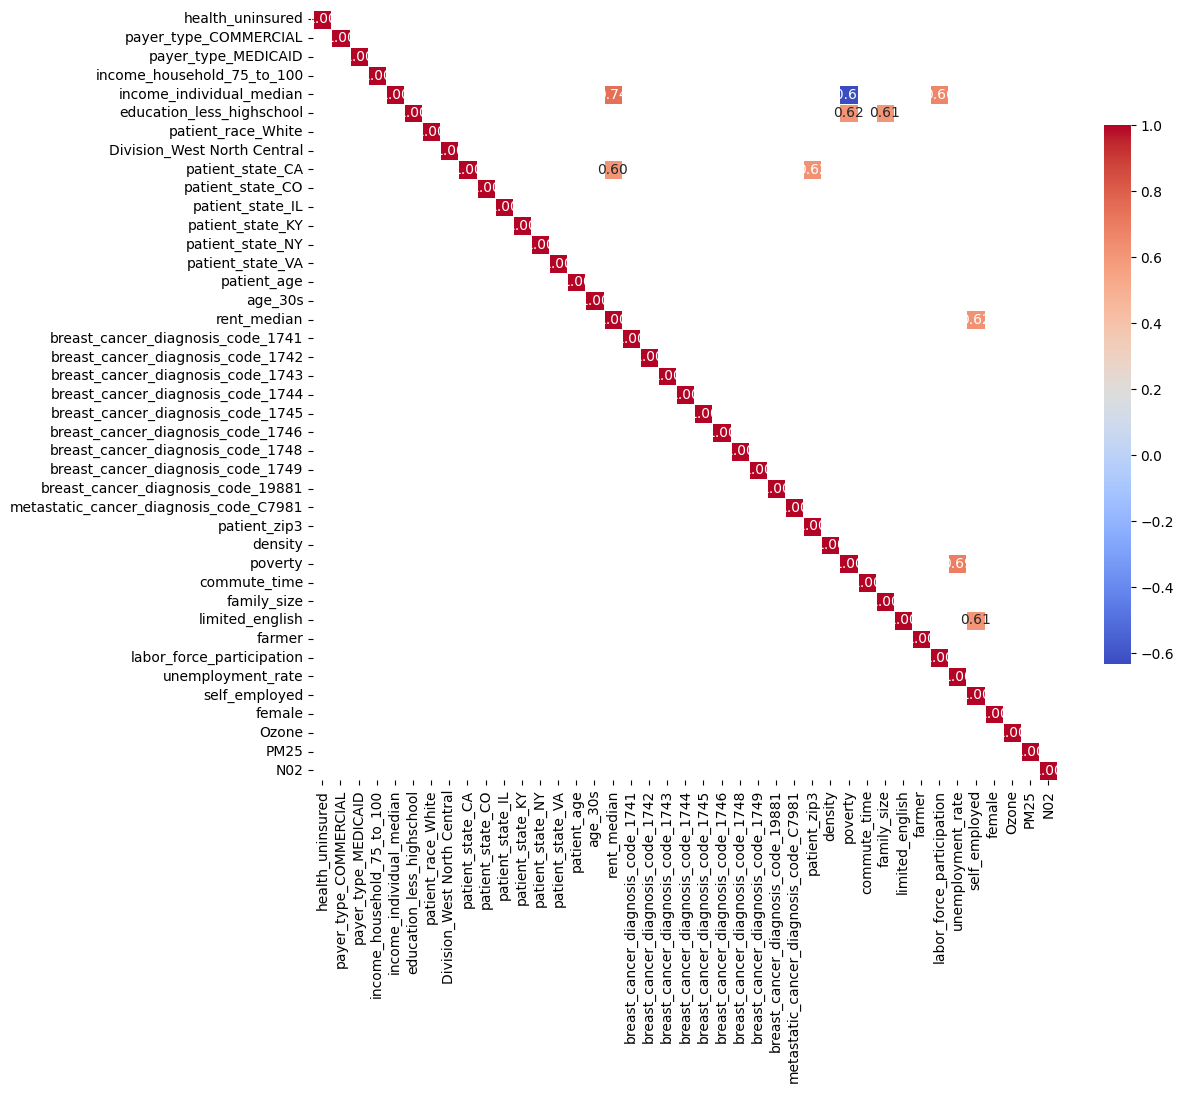

In [145]:
# Define the size of the figure
plt.figure(figsize=(12, 10))

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, cbar_kws={"shrink": 0.7})

# Show the plot
plt.show()

Let's split features on train and test to train the models for the baseline prediction. 

In [146]:
from train_test_simple_models import train_test_models

In [147]:
# best_base_models, base_feature_importances = train_test_models(train_1, target)

In [148]:
best_models, feature_importances_2, pipelines = train_test_models(train_2, target)


Training RandomForest model with GridSearchCV...
Best Parameters for RandomForest: {'classifier__max_depth': 10, 'classifier__n_estimators': 100}
Best Accuracy for RandomForest: 0.8071906263490813

Best RandomForest Model Evaluation:
Accuracy: 0.8062766369624177
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.54      0.67       948
           1       0.78      0.96      0.86      1633

    accuracy                           0.81      2581
   macro avg       0.84      0.75      0.77      2581
weighted avg       0.82      0.81      0.79      2581


Training SVM model with GridSearchCV...
Best Parameters for SVM: {'classifier__C': 10, 'classifier__gamma': 0.1}
Best Accuracy for SVM: 0.812228916793363

Best SVM Model Evaluation:
Accuracy: 0.8113134444013949
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.55      0.68       948
           1       0.79      0.96      0.8

In [149]:
def feature_importance(feature_importances_dict):
    # Display feature importances
    for name, feature_importances in feature_importances_dict.items():
        print(f"\nFeature Importances for {name} model:")
        if feature_importances:
            for feature, importance in sorted(feature_importances.items(), key=lambda x: x[1], reverse=True):
                print(f"{feature}: {importance}")
        else:
            print(f"No feature importances available for {name} model.")


In [150]:
# feature_importance(base_feature_importances)

In [151]:
feature_importance(feature_importances_2)


Feature Importances for RandomForest model:
breast_cancer_diagnosis_code_1749: 0.5060795935529858
breast_cancer_diagnosis_code_1744: 0.10446806470423559
breast_cancer_diagnosis_code_1748: 0.08177397026959177
patient_age: 0.0538988676927461
breast_cancer_diagnosis_code_1742: 0.022839772234851324
breast_cancer_diagnosis_code_1741: 0.019799235209649928
breast_cancer_diagnosis_code_1745: 0.017695679943406283
metastatic_cancer_diagnosis_code_C7981: 0.013189429990798605
labor_force_participation: 0.009785930408315414
Ozone: 0.00902665625121119
commute_time: 0.00814876451572212
N02: 0.00814538469115038
health_uninsured: 0.007985916188102505
income_household_75_to_100: 0.007973258860456219
self_employed: 0.007955329293058802
education_less_highschool: 0.007888972376057499
unemployment_rate: 0.00776791288923961
rent_median: 0.007695732829782424
age_30s: 0.007653264802945423
patient_zip3: 0.007517853198351199
density: 0.007501684358766613
limited_english: 0.007385335004166218
income_individual_

In [152]:
def predict_test_set(pipelines, best_models, test, patient_id):
    """
    Predict the target variable using the provided models on the test set.
    
    Parameters:
        pipelines (dict): Dictionary containing the pipelines for each model.
        best_models (dict): Dictionary containing the best models for each classifier.
        test (pd.DataFrame): Test dataset.
        patient_id (pd.Series): Series containing patient IDs.
        
    Returns:
        predictions (dict): Dictionary containing the predicted values for each model.
    """
    predictions = {}
    for name, model in best_models.items():
        y_pred = model.predict(test)
        predictions[name] = y_pred

    # Insert patient_id to RandomForest predictions
    predictions['RandomForest'] = pd.DataFrame(predictions['RandomForest'], columns=['DiagPeriodL90D'])
    predictions['RandomForest'].insert(0, 'patient_id', patient_id)

    predictions['SVM'] = pd.DataFrame(predictions['SVM'], columns=['DiagPeriodL90D'])
    predictions['SVM'].insert(0, 'patient_id', patient_id)

    predictions['KNN'] = pd.DataFrame(predictions['SVM'], columns=['DiagPeriodL90D'])
    predictions['KNN'].insert(0, 'patient_id', patient_id)

    return predictions['RandomForest'], predictions['SVM'], predictions['KNN']

RandomForest_result, SVM_result, KNN_result = predict_test_set(pipelines, best_models, test_2, patient_id)


In [153]:
SVM_result

,patient_id,DiagPeriodL90D
0,573710,1
1,593679,1
2,184532,1
3,447383,1
4,687972,1
...,...,...
5787,977076,1
5788,922960,1
5789,759690,1
5790,911717,0


In [155]:
train_2.to_csv('train_2.csv', index=False)
test_2.to_csv('test_2.csv',  index=False)
target.to_csv('target.csv', index=False)
RandomForest_result.to_csv('forest_result.csv', index=False)
SVM_result.to_csv('svm_result.csv', index=False)
KNN_result.to_csv('knn_result.csv', index=False)